# Imports

In [27]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns
import numpy as np
np.random.seed(777)
import scipy.optimize as sco


In [28]:
#Set figure sizes
plt.rcParams["figure.figsize"] = (15.0,8.0)


#set font sizes
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

sns.set_style('whitegrid')



In [29]:
plt.style.use('fivethirtyeight')


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Source: https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

to do:

- (DONE) use scipy optimization to find efficient frontier 
- (DONE) implement the function that gives optimal portfolio for given return (efficient_return)

- (DONE) find proper risk free rate: 0.17% currently the 52 week https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=billrates
- **use small cap etf instead of iusn: VB https://etfdb.com/etf/VB/#etf-ticker-valuation-dividend**
- also replace EUNA

- find how far I am from optimal portfolio
- Find sensible change to reduce volatility for the same return

# Functions

In [38]:
def compute_change(dataframe):
    if 'Price' in dataframe.columns:
        dataframe = dataframe[['Date', 'Open', 'Price']][dataframe['Open']!= None]
        dataframe['Open'] = dataframe['Open'].astype(float)
        dataframe['Price'] =dataframe['Price'].astype(float)
        dataframe['Change'] = dataframe['Price'] - dataframe['Open']
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    else:
        dataframe = dataframe[['Date', 'Open', 'Adj Close']][dataframe['Open']!= 'null']
        dataframe['Open'] = dataframe['Open'].astype(float)
        dataframe['Adj Close'] =dataframe['Adj Close'].astype(float)
        dataframe['Change'] = dataframe['Adj Close'] - dataframe['Open']
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    
    return dataframe

def compute_perc_change(dataframe):
    if 'Price' in dataframe.columns:
        dataframe['perc_change'] = dataframe['Price'].pct_change()
    else:
        dataframe['perc_change'] = dataframe['Adj Close'].pct_change()

    return dataframe

def apply_perc_change(portfolio):
    for idx in range(len(portfolio)):
        portfolio[idx] = compute_change(portfolio[idx])
        portfolio[idx] = compute_perc_change(portfolio[idx])
    
    return portfolio

def construct_portfolio_dictionary(dataframes_list, names, weights, description): 
    portfolio_dict = {'names': names,
                 'frames': dataframes_list,
                 'weights': weights,
                  'description': description   }
    
    return portfolio_dict

def print_length(name, dataframe):    
    print(f'Number of days in "{name}" is {len(dataframe)}')
    
def print_date_range(name, dataframe):
    print(f'Date range for "{name}" is from {str(dataframe["Date"].min())}'+ f' to {str(dataframe["Date"].max())}')
          
def plot_ts(dataframe, index):
    if 'Price' in dataframe.columns:
        fig = dataframe.plot(x='Date', y = 'Price')
        
    else: 
        fig = dataframe.plot(x='Date', y = 'Adj Close')
                             
    plt.title(index)
    plt.xlabel('Date');
    plt.ylabel('Closing Price')
    
    plt.show()
          
def compute_return_since_inception(dataframe):
    if 'Price' in dataframe.columns:
        p0 = float(dataframe[dataframe['Date'] == dataframe['Date'].min()]['Price'])
        p1 = float(dataframe[dataframe['Date'] == dataframe['Date'].max()]['Price'])
    else:
        
        p0 = float(dataframe[dataframe['Date'] == dataframe['Date'].min()]['Adj Close'])
        p1 = float(dataframe[dataframe['Date'] == dataframe['Date'].max()]['Adj Close'])
    
    return (p1-p0)/p0

def print_return_since_inception(dataframe, name):
    returns_since_inception = compute_return_since_inception(dataframe)
    
    print(f'The returns since inception {str(dataframe["Date"].min().date())} for "{name}" is {round(returns_since_inception*100,2)}%')
          
                 
def find_intersection(list_df):
    #Filter only non-null values
    for idx in range(len(list_df)):
        list_df[idx] = list_df[idx][list_df[idx]['perc_change'].notnull()]
    
    intersection_list = set(list_df[0]['Date']).intersection(set(list_df[1]['Date']))
    for df in list_df[2:]:
        intersection_list = intersection_list.intersection(set(df['Date']))
    
    common_dates = pd.Series(list(intersection_list))  
    
    minimum_date = str(common_dates.min().date())
    maximum_date = str(common_dates.max().date())
          
    return common_dates, minimum_date, maximum_date
          
def intersect_dataframes(list_df): 
    # Common lengths
    
    intersection = list_df.copy()
    common_dates, _, _ = find_intersection(intersection)
    for idx in range(len(intersection)):
        intersection[idx] = intersection[idx][intersection[idx]['Date'].isin(common_dates)]
        
    return intersection
                    

def create_matrix(list_df):
    intersected = intersect_dataframes(list_df)
    array_list = []

    for df in intersected:
        array_list.append(np.array(df['perc_change']))
    matrix = np.array(array_list)
    
    return matrix
              

def compute_correlation_matrix(list_df):
    matrix = create_matrix(list_df)
    corrMatrix = np.corrcoef(matrix)
    
    return corrMatrix
          
def compute_covariance_matrix(list_df):
    matrix = create_matrix(list_df)

    covMatrix = np.cov(matrix, bias=True)
    return covMatrix
          
def plot_correlation_matrix(list_df, names):
    corr = compute_correlation_matrix(list_df)
    
    corrMatrix = pd.DataFrame(corr, columns = names, index = names)
    if len(list_df)<=4:
        fig = plt.subplots(figsize=(15,10))
    else:
        fig= plt.subplots(figsize=(20,10)) 
    
    sns.heatmap(corrMatrix, annot=True, fmt='g')
    plt.title('Correlation matrix')
    
    plt.show()
          
def plot_covariance_matrix(list_df, names):
    cov = compute_covariance_matrix(list_df)
    
    covMatrix = pd.DataFrame(cov, columns = names, index = names)
    if len(list_df)<=4:
        fig = plt.subplots(figsize=(15,10))
    else:
        fig= plt.subplots(figsize=(20,10)) 

    sns.heatmap(covMatrix, annot=True, fmt='g')
    plt.title('Covariance matrix')

    plt.show()
   

def compute_mean_daily_returns(portfolio_dictionary):
    intersected = intersect_dataframes(portfolio_dictionary['frames'])
     # Compute mean daily return per ETF
    mean_daily_returns = []
    for df in intersected:
        mean_daily_returns.append(df['perc_change'].mean())
    
    return mean_daily_returns
          
def compute_annualized_returns_no_intersection(portfolio_dictionary):
     # Compute mean daily return per ETF, using all the years
    mean_daily_returns = []
    for df in portfolio_dictionary['frames']:
        mean_daily_returns.append(df['perc_change'].mean())
    
    weights = np.array(portfolio_dictionary['weights'])

    portfolio_returns = np.sum(mean_daily_returns*weights ) *252
              
    return portfolio_returns

def portfolio_annualised_performance(portfolio_dictionary):
    cov_matrix = compute_covariance_matrix(portfolio_dictionary['frames']) 

    weights = np.array(portfolio_dictionary['weights'])

    mean_daily_returns = compute_mean_daily_returns(portfolio_dictionary)
          
    portfolio_returns = np.sum(mean_daily_returns*weights ) *252
    
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    return portfolio_returns, portfolio_std

def random_portfolios(num_portfolios, portfolio, names, risk_free_rate, description):
    
    for idx in range(len(portfolio)):
        portfolio[idx] = compute_perc_change(portfolio[idx])
    
    num_etfs = len(portfolio)
    
    results = np.zeros((3,num_portfolios))
    weights_record = []
    
    
    
    for idx in range(num_portfolios):
        # generate num_etfs random numbers
        weights = np.random.random(num_etfs)
        # Make sure that their sum, sums up to 1
        weights /= np.sum(weights)
        weights_record.append(weights)
    
        portfolio_dict = construct_portfolio_dictionary(portfolio, names, weights, description)
        
        portfolio_returns, portfolio_std = portfolio_annualised_performance(portfolio_dict)
        
        results[0,idx] = portfolio_std
        results[1,idx] = portfolio_returns
        results[2,idx] = (portfolio_returns - risk_free_rate) / portfolio_std
        
    return results, weights_record
          
def display_simulated_ef_with_random(portfolio, names, num_portfolios, risk_free_rate, description):
    results, weights = random_portfolios(num_portfolios, portfolio, names, risk_free_rate, description)
        
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=names,columns=['allocation'])
    #max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.apply(lambda x: round(x*100,2))
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=names,columns=['allocation'])
    #min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.apply(lambda x: round(x*100,2))
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(15, 10))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title(f'Efficient Frontier: {num_portfolios} simulated portfolios', size=25)
    plt.xlabel('Annualised volatility', size = 20)
    plt.ylabel('Annualised returns', size = 20)
    plt.legend(labelspacing=0.8)
    
    plt.savefig(f'figures/efficient_frontier_{num_portfolios}_portfolios.png', dpi=250)
    plt.show();
          

# Analysis

In [31]:
#path = '/Users/Fosa/PythonProjects/git_tree/portfolio_management/Portfolio Management/Historical_data'
path = '/Users/gchouliaras/git_tree/portfolio_management/Portfolio Management/Historical_data'

In [32]:
# Load dataframes
EMIM = pd.read_csv(f'{path}/EMIM.AS.csv')
EUNA = pd.read_csv(f'{path}/EUNA.csv')
IEAG = pd.read_csv(f'{path}/IEAG.AS.csv')
IWDA = pd.read_csv(f'{path}/IWDA.AS.csv')
IUSN = pd.read_csv(f'{path}/IUSN.csv')
IWVL = pd.read_csv(f'{path}/IWVL.csv')
TRET = pd.read_csv(f'{path}/TRET.csv')

In [33]:
# Construct portfolio

portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']
description = ['Developed Markets', 'Emerging Markets', 'World Small Cap', 'World Value', 'REIT', 'EU bond ETF', 'Global bond ETF']
weights = [0.36, 0.12, 0.12, 0.12, 0.08, 0.1, 0.1]


In [34]:
# Add absolute and percentage change, and set Date to Datetime

portfolio = apply_perc_change(portfolio)

# Construt dictionary of the portfolio
portfolio_dict = construct_portfolio_dictionary(portfolio, names, weights, description)

In [35]:
# Print length of each dataframe
for idx in range(len(portfolio_dict['names'])):
    print_length(portfolio_dict['names'][idx], portfolio_dict['frames'][idx])

Number of days in "IWDA" is 2736
Number of days in "EMIM" is 1550
Number of days in "IWVL" is 1301
Number of days in "IUSN" is 544
Number of days in "TRET" is 2350
Number of days in "EUNA" is 634
Number of days in "IEAG" is 2844


In [36]:
for idx in range(len(portfolio_dict['names'])):
    print_date_range(portfolio_dict['names'][idx], portfolio_dict['frames'][idx])

Date range for "IWDA" is from 2009-10-13 00:00:00 to 2020-06-24 00:00:00
Date range for "EMIM" is from 2014-06-02 00:00:00 to 2020-06-24 00:00:00
Date range for "IWVL" is from 2015-02-17 00:00:00 to 2020-06-25 00:00:00
Date range for "IUSN" is from 2018-04-26 00:00:00 to 2020-06-25 00:00:00
Date range for "TRET" is from 2011-04-15 00:00:00 to 2020-06-26 00:00:00
Date range for "EUNA" is from 2017-12-15 00:00:00 to 2020-06-26 00:00:00
Date range for "IEAG" is from 2009-05-14 00:00:00 to 2020-06-24 00:00:00



# To do

Find: 

- return since inception (DONE)
- yearly returns (DONE)
- average yearly return 
- standard deviation: sqrt(average yearly return / number of years) (DONE)
- covariance of the portfolio (DONE)



- Check if it makes sense to compute returns of portfolio using larger time periods
- find efficinet frontier
- Use another small cap index to have more data
- polish script and upload git

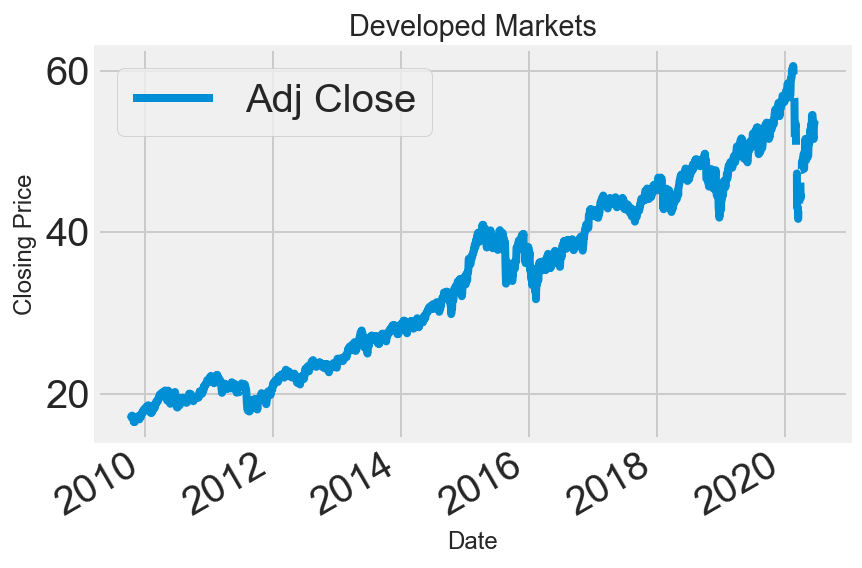

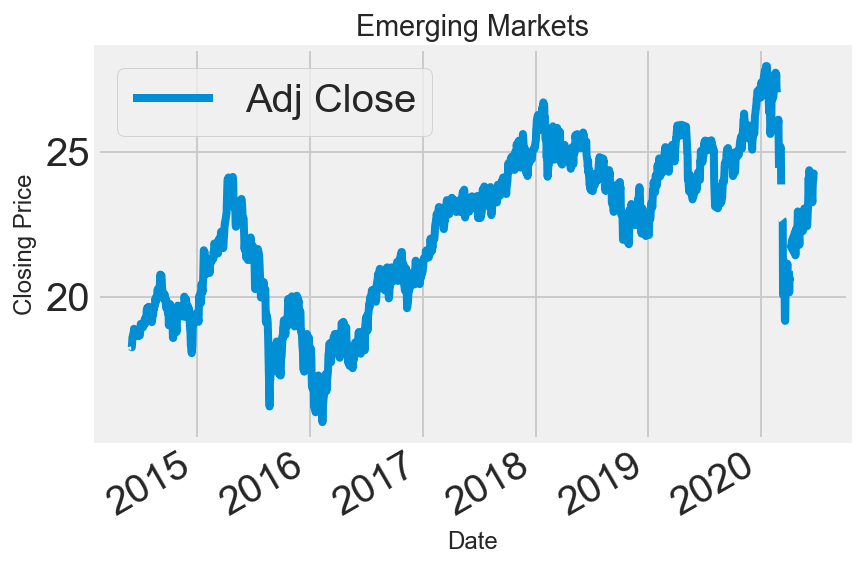

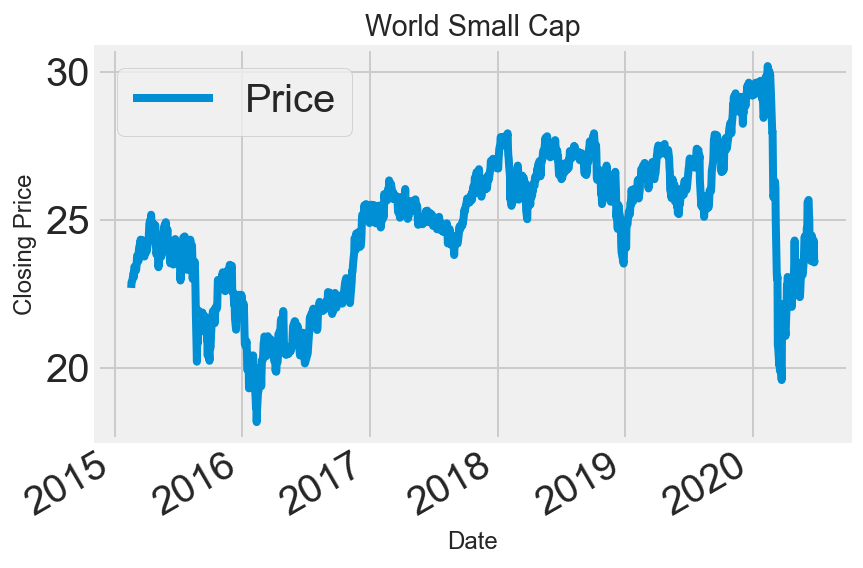

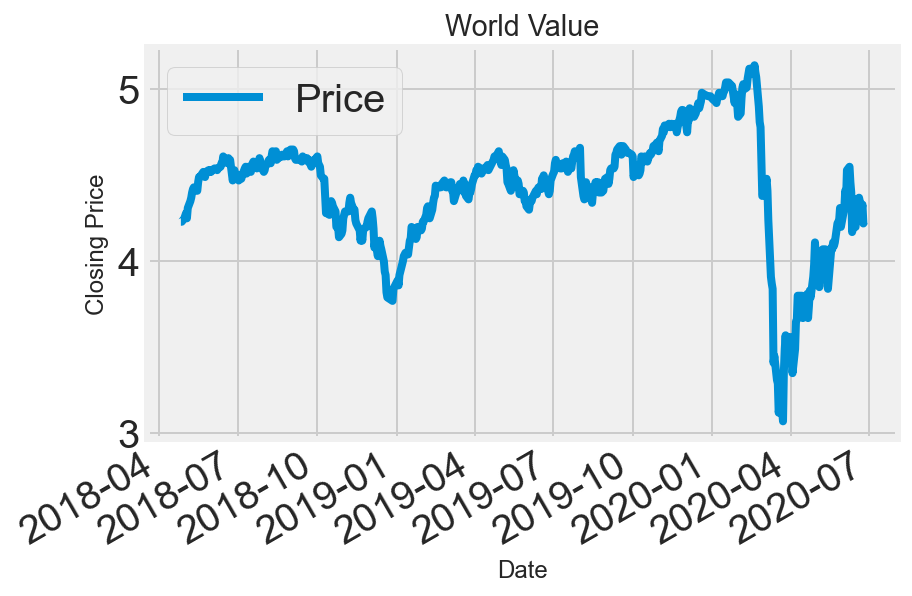

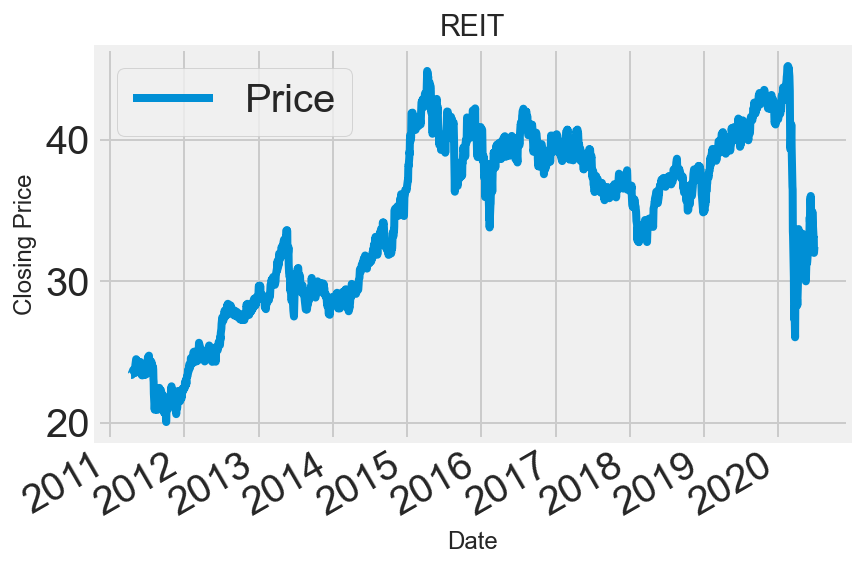

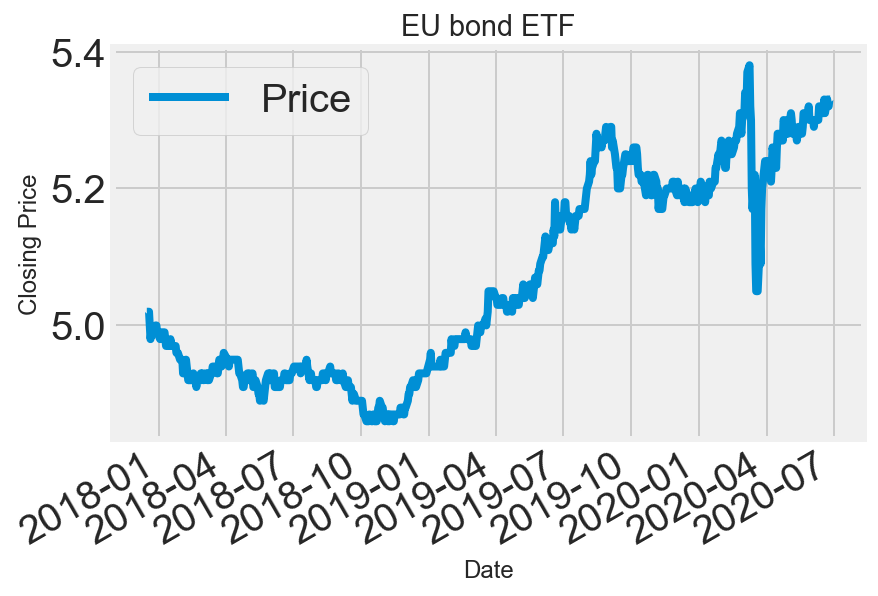

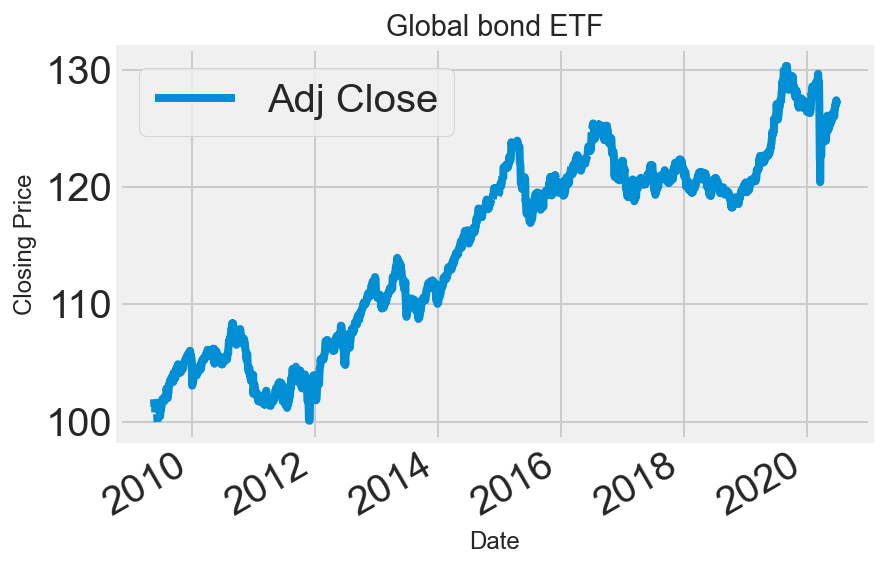

In [24]:
for idx in range(len(portfolio_dict['names'])):
    plot_ts(portfolio_dict['frames'][idx], portfolio_dict['description'][idx])

## Covariance matrix

In [ ]:
# Compute covariance and correlation matrices
corr_matrix = compute_correlation_matrix(portfolio_dict['frames'])
cov_matrix = compute_covariance_matrix(portfolio_dict['frames'])



In [ ]:
# Plot correlation matrix
plot_correlation_matrix(portfolio_dict['frames'], portfolio_dict['names'])

In [ ]:
# Plot covariance matrix
plot_covariance_matrix(portfolio_dict['frames'], portfolio_dict['names'])

## Compute risk and return of the portfolio

In [ ]:
portfolio_returns, portfolio_std = portfolio_annualised_performance(portfolio_dict)
_, min_date, max_date = find_intersection(portfolio_dict['frames'])

print(f'The annualized return of the portfolio is {round(portfolio_returns*100,2)}% and the risk is {round(portfolio_std*100,2)}%' )
print('\n')
print(f'The portfolio minimum date is {min_date} and maximum date is {max_date}')

In [ ]:
# Compute return of portfolio without constraining the time periods 

portfolio_returns_no_intersection = compute_annualized_returns_no_intersection(portfolio_dict)
print(f'The portfolio returns using all the years in all ETFs are {round(portfolio_returns_no_intersection*100,2)}%')

- This number does not tell much, because we do not account for past returns of the ETFs that have short periods.

- Compute efficient frontier

# Generate random portfolios

In [ ]:
### Not working, fix
portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']
description = ['Developed Markets', 'Emerging Markets', 'World Small Cap', 'World Value', 'REIT', 'EU bond ETF', 'Global bond ETF']



results, weights_record = random_portfolios(5, portfolio, names, risk_free_rate=0.0178, description=description)

## Plot the portfolios

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.11


             IWDA  EMIM   IWVL  IUSN   TRET  EUNA   IEAG
allocation  21.53  2.22  31.73  1.55  19.67  2.39  20.91
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.03
Annualised Volatility: 0.06


            IWDA  EMIM   IWVL  IUSN  TRET   EUNA   IEAG
allocation  6.02  14.4  12.79  2.06  5.64  32.92  26.18


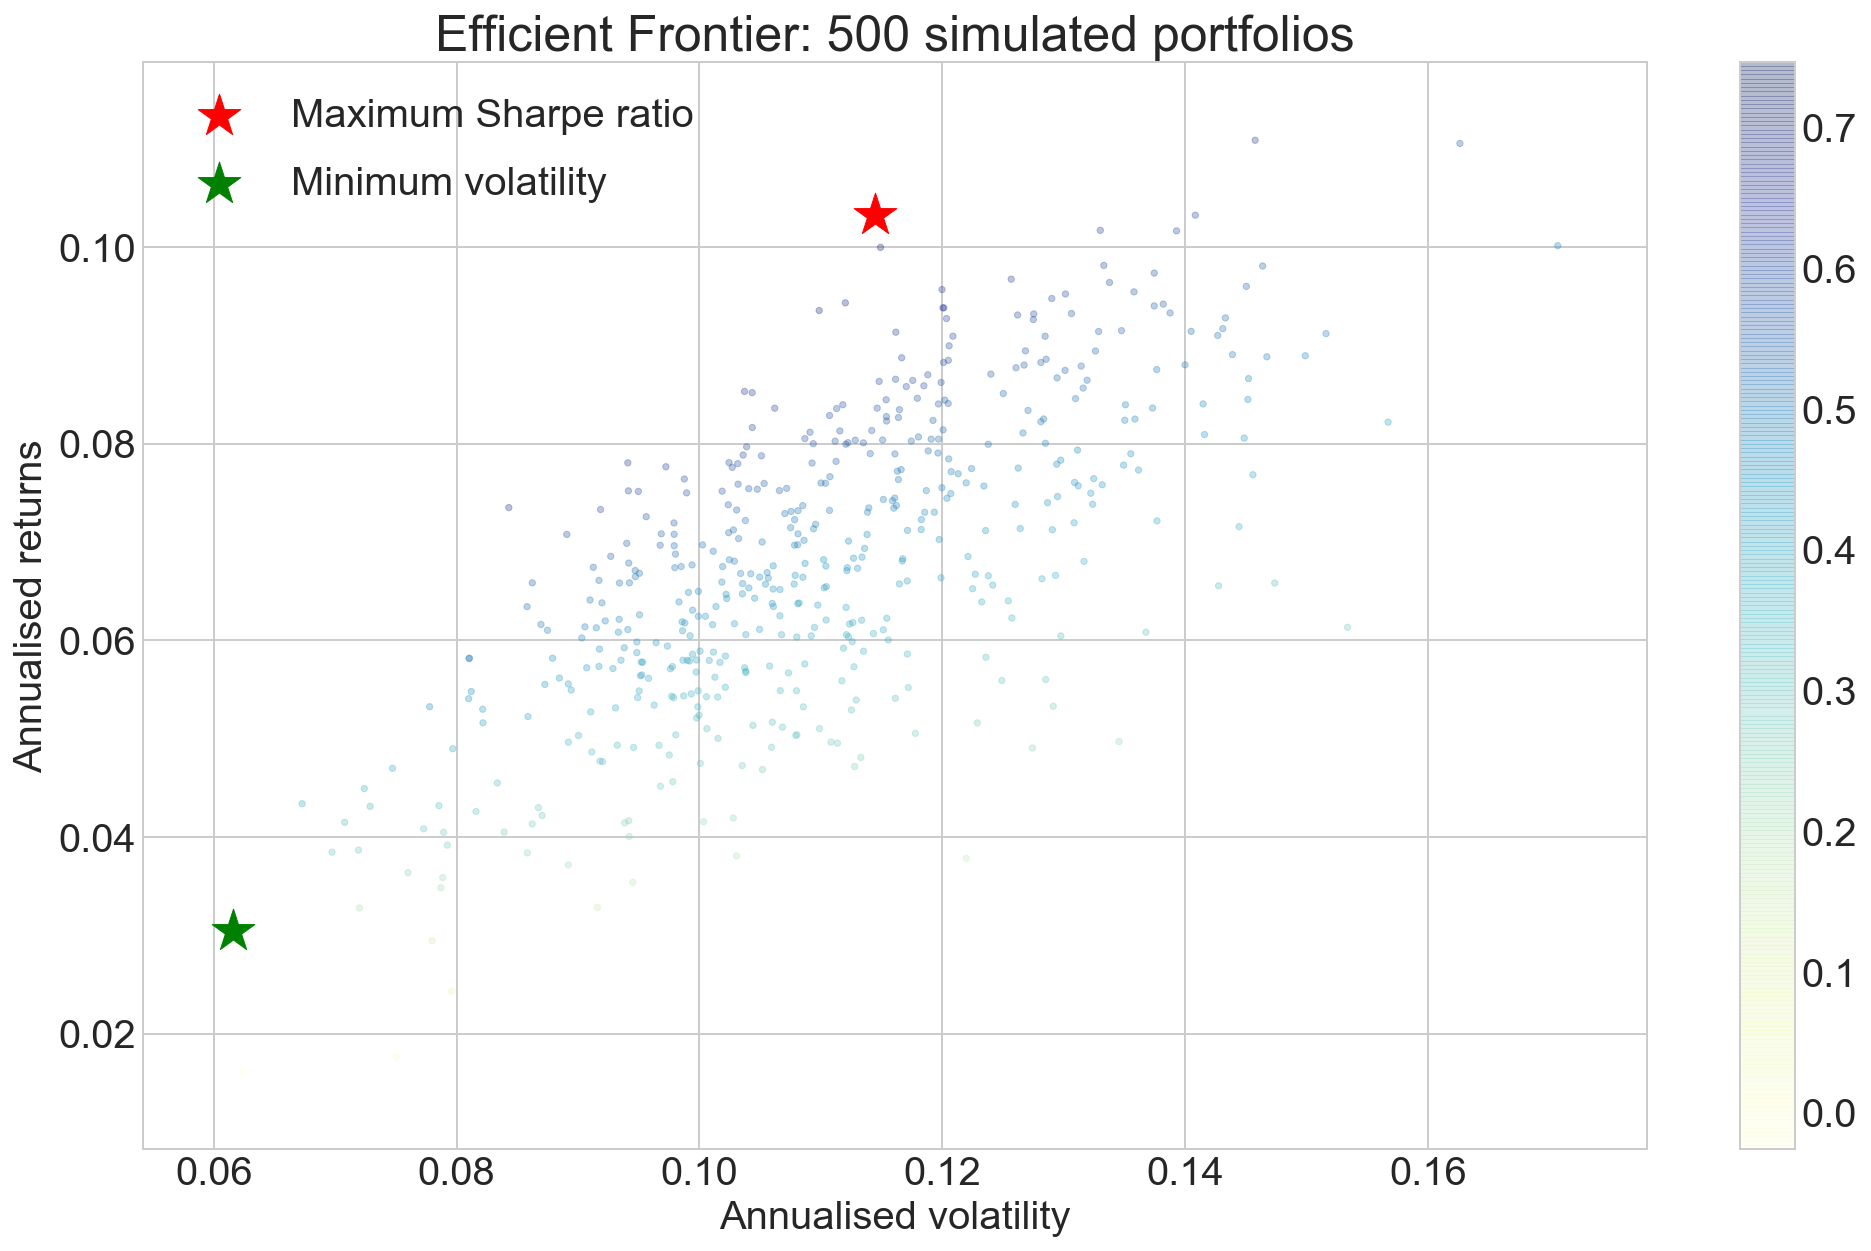

In [22]:
# Display many portfolios

portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']
description = ['Developed Markets', 'Emerging Markets', 'World Small Cap', 'World Value', 'REIT', 'EU bond ETF', 'Global bond ETF']



for idx in range(len(portfolio)):
    portfolio[idx] = compute_change(portfolio[idx])
    portfolio[idx] = compute_perc_change(portfolio[idx])

num_portfolios = 500
num_etfs = len(portfolio)
risk_free_rate = 0.0178


display_simulated_ef_with_random(portfolio, names, num_portfolios, risk_free_rate, description)

In [ ]:
# Display many portfolios

portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']

for idx in range(len(portfolio)):
    portfolio[idx] = compute_change(portfolio[idx])
    portfolio[idx] = compute_perc_change(portfolio[idx])

num_portfolios = 80000
num_etfs = len(portfolio)
risk_free_rate = 0.0178


display_simulated_ef_with_random(portfolio, names, num_portfolios, risk_free_rate)

In [ ]:
# Display many portfolios

portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']

for idx in range(len(portfolio)):
    portfolio[idx] = compute_change(portfolio[idx])
    portfolio[idx] = compute_perc_change(portfolio[idx])

num_portfolios = 55000
num_etfs = len(portfolio)
risk_free_rate = 0.0178

display_simulated_ef_with_random(portfolio, names, num_portfolios, risk_free_rate)

In [ ]:
# Display many portfolios

portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']

for idx in range(len(portfolio)):
    portfolio[idx] = compute_change(portfolio[idx])
    portfolio[idx] = compute_perc_change(portfolio[idx])

num_portfolios = 55000
num_etfs = len(portfolio)
risk_free_rate = 0.0178

display_simulated_ef_with_random(portfolio, names, num_portfolios, risk_free_rate)

### Try with fewer assets

In [ ]:
# Display many portfolios

portfolio = [IWDA, IEAG]
names = ['IWDA', 'IEAG']
description = ['World', 'Global BOND']

for idx in range(len(portfolio)):
    portfolio[idx] = compute_change(portfolio[idx])
    portfolio[idx] = compute_perc_change(portfolio[idx])

num_portfolios = 3000
num_etfs = len(portfolio)
risk_free_rate = 0.17 / 100

display_simulated_ef_with_random(portfolio, names, num_portfolios, risk_free_rate, description)

In [ ]:
# DEBUG THIS!!!!!!!!!!!!!!!
# Display many portfolios

portfolio = [IWDA, EMIM, IEAG]
names = ['IWDA', 'EMIM', 'IEAG']
description = ['World', 'Emerging']
for idx in range(len(portfolio)):
    portfolio[idx] = compute_change(portfolio[idx])
    portfolio[idx] = compute_perc_change(portfolio[idx])

num_portfolios = 500
num_etfs = len(portfolio)
risk_free_rate = 0.17 / 100

display_simulated_ef_with_random(portfolio, names, num_portfolios, risk_free_rate, description)

# Use scipy to find optimal portfolios

In [15]:
# Correct way


# Create neg_sharpe_ratio by using weights

def neg_sharpe_ratio(weights, portfolio, names, risk_free_rate):
    """
    Computes the negative sharpe ratio
    """
    
    portfolio_dictionary = construct_portfolio_dictionary(portfolio, names, weights, ["NA"])
    p_ret, p_std = portfolio_annualised_performance(portfolio_dictionary)
    return -(p_ret - risk_free_rate) / p_std

def portfolio_volatility(weights, portfolio, names):
    """
    Computes the portfolio's volatility
    """
    
    portfolio_dictionary = construct_portfolio_dictionary(portfolio, names, weights, ["NA"])
    p_ret, p_std = portfolio_annualised_performance(portfolio_dictionary)
    return p_std

def max_sharpe_ratio(portfolio, names, risk_free_rate):
    """
    Maximizes the sharpe ratio
    """
    
    num_assets = len(portfolio)
    args = (portfolio, names, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

def min_variance(portfolio, names):
    """
    Minimizes the variance
    """
    
    num_assets = len(portfolio)
    args = (portfolio, names)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

In [26]:
# Test the maximization of the sharpe ratio
portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']
description = ['Developed Markets', 'Emerging Markets', 'World Small Cap', 'World Value', 'REIT', 'EU bond ETF', 'Global bond ETF']

portfolio = apply_perc_change(portfolio)


#num_etfs = len(portfolio)
risk_free_rate = 0.0178
#weights = [0.36, 0.12, 0.12, 0.12, 0.08, 0.1, 0.1]

max_sharpe_result = max_sharpe_ratio(portfolio, names, risk_free_rate)
min_variance_result = min_variance(portfolio, names)

In [27]:
# Add efficient return
target = 0.08

num_assets = len(portfolio)

def portfolio_return(weights):
    
    portfolio_dictionary = construct_portfolio_dictionary(portfolio, names, weights, ["NA"])
    p_ret, _ = portfolio_annualised_performance(portfolio_dictionary)
    
    return p_ret

args = (portfolio, names)
constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(num_assets))
result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)    

In [14]:
def efficient_return(portfolio, names, target_return):
    """
    Finds the weights for minimal volatility given target_return
    """
    
    num_assets = len(portfolio)

    def portfolio_return(weights):
        
        portfolio_dictionary = construct_portfolio_dictionary(portfolio, names, weights, ["NA"])
        p_ret, _ = portfolio_annualised_performance(portfolio_dictionary)
        
        return p_ret
    
    args = (portfolio, names)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target_return},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

def efficient_frontier(portfolio, names, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(portfolio, names, ret))
    return efficients

In [29]:
# Test efficient frontier
portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']
description = ['Developed Markets', 'Emerging Markets', 'World Small Cap', 'World Value', 'REIT', 'EU bond ETF', 'Global bond ETF']

portfolio = apply_perc_change(portfolio)

efficient_return(portfolio, names, target_return = 0.05)



     fun: 0.03443984808713823
     jac: array([ 0.05468989,  0.05953893,  0.06634814,  0.06224483,  0.05169738,
        0.00162235,  0.03377442])
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.03485094,  0.        ,  0.04918659,  0.        ,  0.0033312 ,
        0.0536635 ,  0.85896777])

In [ ]:
rp_min = 0.05
np.linspace(rp_min, 0.32, 50)

In [ ]:
rp_min = 0.05
returns_range = np.linspace(rp_min, 0.08, 50) # Creates a range of possible returns from 5% to 32%

In [ ]:
efficient_frontier(portfolio, names, returns_range)

# Plot the efficient frontier computed with Scipy

In [30]:
def display_simulated_ef_with_random(portfolio, names, num_portfolios, risk_free_rate, description):
    results, weights = random_portfolios(num_portfolios, portfolio, names, risk_free_rate, description)
        
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=names,columns=['allocation'])
    #max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.apply(lambda x: round(x*100,2))
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=names,columns=['allocation'])
    #min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.apply(lambda x: round(x*100,2))
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(15, 10))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title(f'Efficient Frontier: {num_portfolios} simulated portfolios', size=25)
    plt.xlabel('Annualised volatility', size = 20)
    plt.ylabel('Annualised returns', size = 20)
    plt.legend(labelspacing=0.8)
    
    plt.savefig(f'figures/efficient_frontier_{num_portfolios}_portfolios.png', dpi=250)
    plt.show();

In [12]:
def display_calculated_ef_with_random(portfolio, names, num_portfolios, risk_free_rate, max_return, num_samples):
    
    #results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    results, _ = random_portfolios(num_portfolios, portfolio, names, risk_free_rate, ['NA'])
    
    max_sharpe = max_sharpe_ratio(portfolio, names, risk_free_rate)

    #sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    
    portfolio_dictionary = construct_portfolio_dictionary(portfolio, names, weights, ["NA"])
    p_ret, p_std = portfolio_annualised_performance(portfolio_dictionary)
    
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=names,columns=['allocation'])
    #max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.apply(lambda x: round(x*100,2))
    max_sharpe_allocation = max_sharpe_allocation.T

    
    
    # FIX MIN VOL
    min_vol = min_variance(portfolio, names)
    
    #sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    
    portfolio_dictionary = construct_portfolio_dictionary(portfolio, names, min_vol['x'], ["NA"])
    p_ret_min, p_std_min = portfolio_annualised_performance(portfolio_dictionary)

    
    min_vol_allocation = pd.DataFrame(min_vol.x,index=names,columns=['allocation'])
    #min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.apply(lambda x: round(x*100,2))
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(p_ret,2))
    print("Annualised Volatility:", round(p_std,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(p_ret_min,2))
    print("Annualised Volatility:", round(p_std_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(15, 10))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(p_std,p_ret,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(p_std_min,p_ret_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(p_ret_min, max_return, num_samples)
    efficient_portfolios =  efficient_frontier(portfolio, names, target)
   
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier', size=25)
    plt.xlabel('annualised volatility', size = 20)
    plt.ylabel('annualised returns', size = 20)
    plt.legend(labelspacing=0.8)
    
    plt.show();

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.11


            IWDA  EMIM  IWVL  IUSN  TRET  EUNA   IEAG
allocation  5.97   0.0  8.62   0.0   0.0   0.0  85.41
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.0
Annualised Volatility: 0.03


            IWDA  EMIM  IWVL  IUSN  TRET   EUNA   IEAG
allocation  1.65   0.0  2.11   0.0   0.0  45.92  50.32


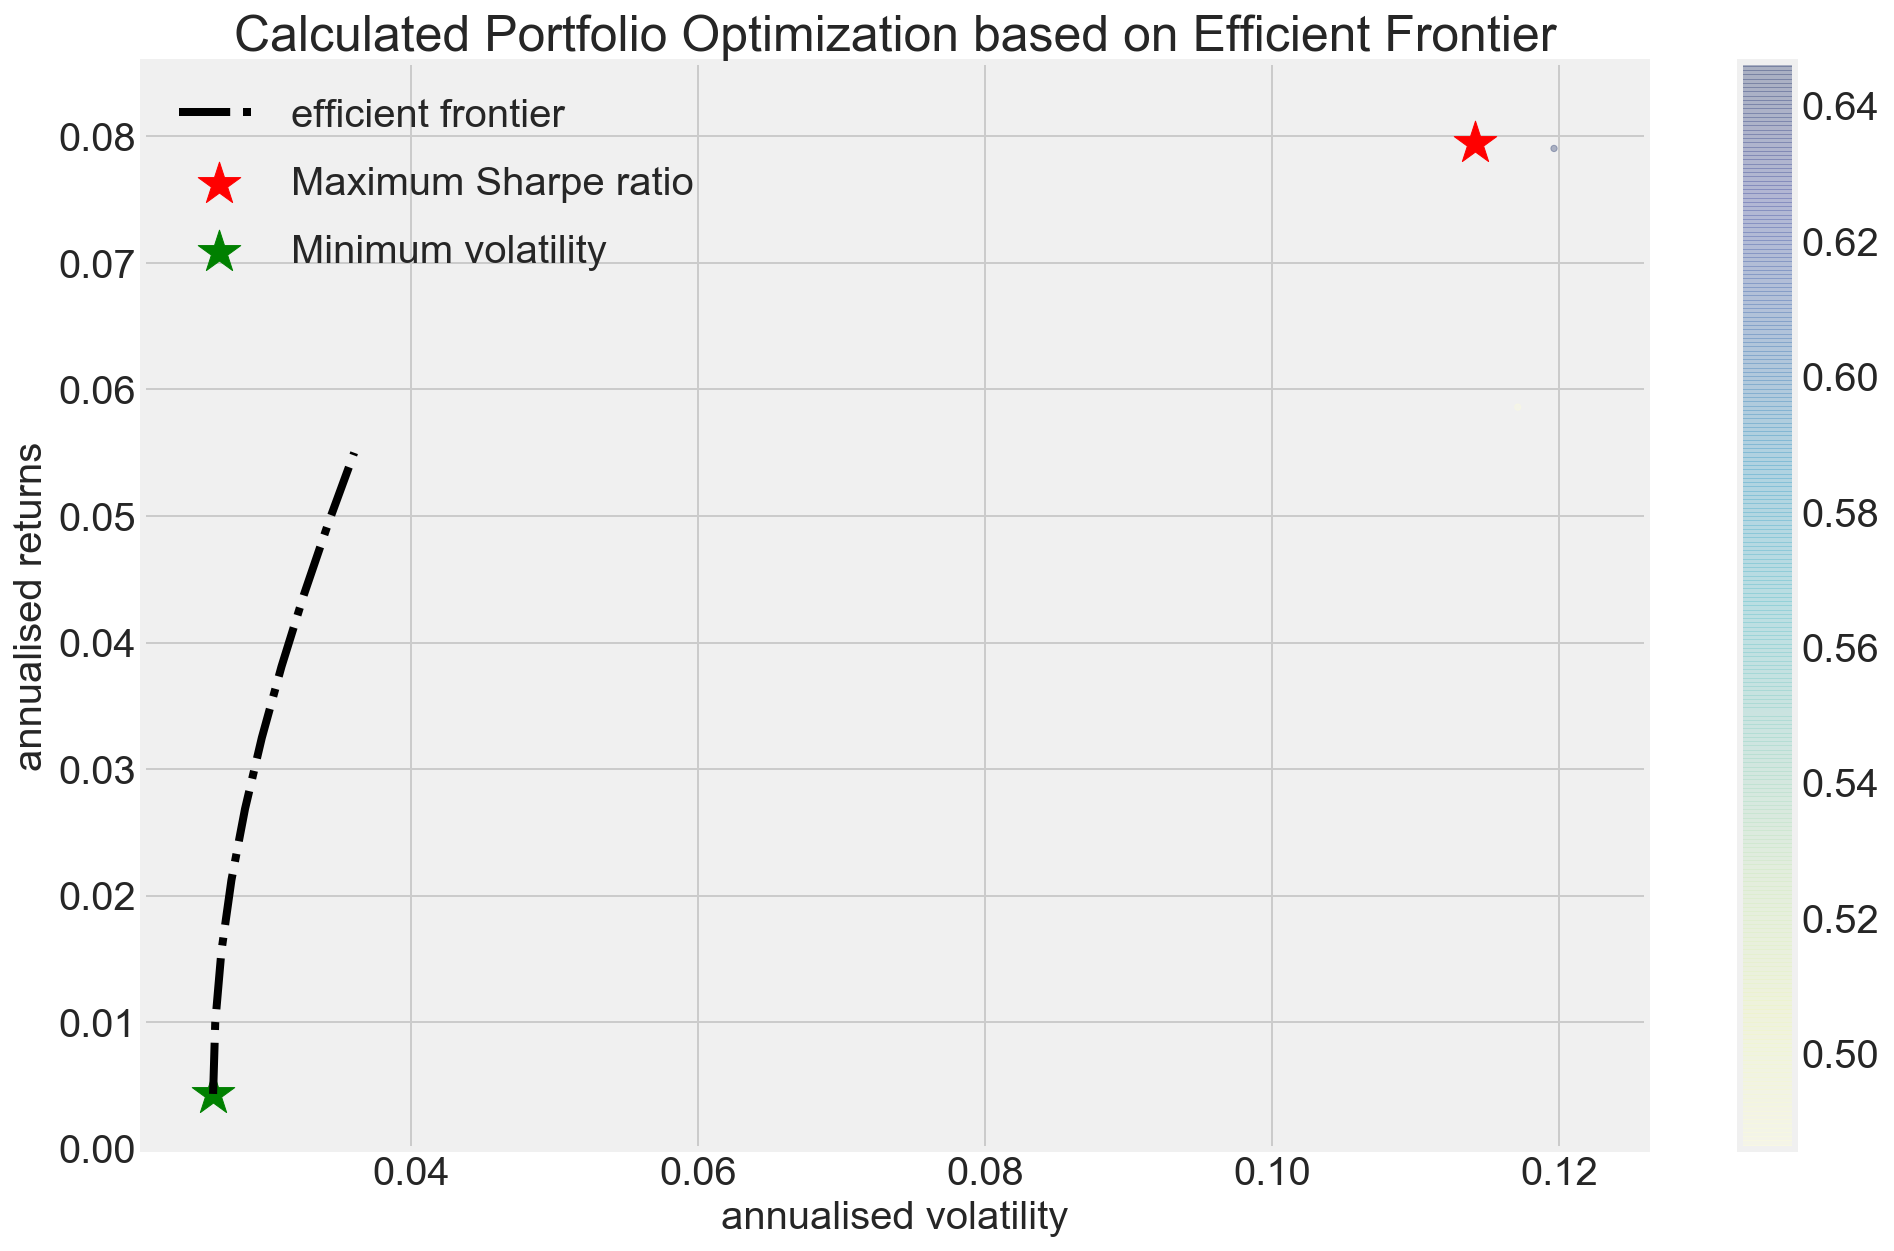

In [16]:
# Test the display of the efficient frontier

portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']
description = ['Developed Markets', 'Emerging Markets', 'World Small Cap', 'World Value', 'REIT', 'EU bond ETF', 'Global bond ETF']

portfolio = apply_perc_change(portfolio)

num_portfolios = 2
risk_free_rate = 0.17 / 100

display_calculated_ef_with_random(portfolio, names, num_portfolios, risk_free_rate, max_return=0.055, num_samples=10)

## Plot current allocation versus efficient frontier

In [17]:
def display_ef_with_selected(portfolio, names, num_portfolios, risk_free_rate, max_return, num_samples):
    results, _ = random_portfolios(num_portfolios, portfolio, names, risk_free_rate, ['NA'])
    
    max_sharpe = max_sharpe_ratio(portfolio, names, risk_free_rate)
    
    #max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    
    portfolio_dictionary = construct_portfolio_dictionary(portfolio, names, weights, ["NA"])
    p_ret, p_std = portfolio_annualised_performance(portfolio_dictionary)
    
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=names,columns=['allocation'])
    max_sharpe_allocation = max_sharpe_allocation.apply(lambda x: round(x*100,2))
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(portfolio, names)
    portfolio_dictionary = construct_portfolio_dictionary(portfolio, names, min_vol['x'], ["NA"])
    p_ret_min, p_std_min = portfolio_annualised_performance(portfolio_dictionary)

    
    min_vol_allocation = pd.DataFrame(min_vol.x,index=names,columns=['allocation'])
    #min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.apply(lambda x: round(x*100,2))
    min_vol_allocation = min_vol_allocation.T
    
   # mean_daily_returns.append(df['perc_change'].mean())
    #mean_daily_returns = 
    
    # Todo: create function for this functionality
    # Find the standard deviation and mean of perc_change of each ETF
    mean_returns = []
    std_returns = []

    for etf in portfolio:
        mean_daily_return = etf['perc_change'].mean()    
        mean_returns.append(mean_daily_return)
        
        ret = etf['perc_change'].std()    
        std_returns.append(ret)
                
    
    # Annualized returns and volatility
    an_vol = np.array(std_returns) * np.sqrt(252)
    an_rt = np.array(mean_returns) * 252 
    
    #an_vol = np.std(returns) * np.sqrt(252)
    #an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(p_ret,2))
    print("Annualised Volatility:", round(p_std,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(p_ret_min,2))
    print("Annualised Volatility:", round(p_std_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(names):
        print(txt,":","annualised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(names):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(p_std,p_ret, marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(p_std_min, p_ret_min, marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, max_return, num_samples)
    
    efficient_portfolios =  efficient_frontier(portfolio, names, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks', size = 25)
    ax.set_xlabel('annualised volatility', size = 20)
    ax.set_ylabel('annualised returns', size = 20)
    ax.legend(labelspacing=0.8)
    
    plt.show()
    

In [ ]:
# Test the display of the efficient frontier

portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']
description = ['Developed Markets', 'Emerging Markets', 'World Small Cap', 'World Value', 'REIT', 'EU bond ETF', 'Global bond ETF']

portfolio = apply_perc_change(portfolio)

num_portfolios = 100
risk_free_rate = 0.17 / 100

display_ef_with_selected(portfolio, names, num_portfolios, risk_free_rate, max_return= 0.09, num_samples = 40)

In [ ]:
# Test the display of the efficient frontier

portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']
description = ['Developed Markets', 'Emerging Markets', 'World Small Cap', 'World Value', 'REIT', 'EU bond ETF', 'Global bond ETF']

portfolio = apply_perc_change(portfolio)

num_portfolios = 100
risk_free_rate = 0.17 / 100

display_ef_with_selected(portfolio, names, num_portfolios, risk_free_rate, max_return= 0.09, num_samples = 40)

In [ ]:
# Test the display of the efficient frontier

portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']
description = ['Developed Markets', 'Emerging Markets', 'World Small Cap', 'World Value', 'REIT', 'EU bond ETF', 'Global bond ETF']

portfolio = apply_perc_change(portfolio)

num_portfolios = 50
risk_free_rate = 0.17 / 100

display_ef_with_selected(portfolio, names, num_portfolios, risk_free_rate, max_return= 0.35, num_samples = 40)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.11


            IWDA  EMIM  IWVL  IUSN  TRET  EUNA   IEAG
allocation  5.97   0.0  8.62   0.0   0.0   0.0  85.41
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.0
Annualised Volatility: 0.03


            IWDA  EMIM  IWVL  IUSN  TRET   EUNA   IEAG
allocation  1.65   0.0  2.11   0.0   0.0  45.92  50.32
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

IWDA : annualised return 0.12 , annualised volatility: 0.16
EMIM : annualised return 0.07 , annualised volatility: 0.2
IWVL : annualised return 0.01 , annualised volatility: 0.2
IUSN : annualised return 0.03 , annualised volatility: 0.23
TRET : annualised return -0.02 , annualised volatility: 0.17
EUNA : a

NameError: name 'rp_min' is not defined

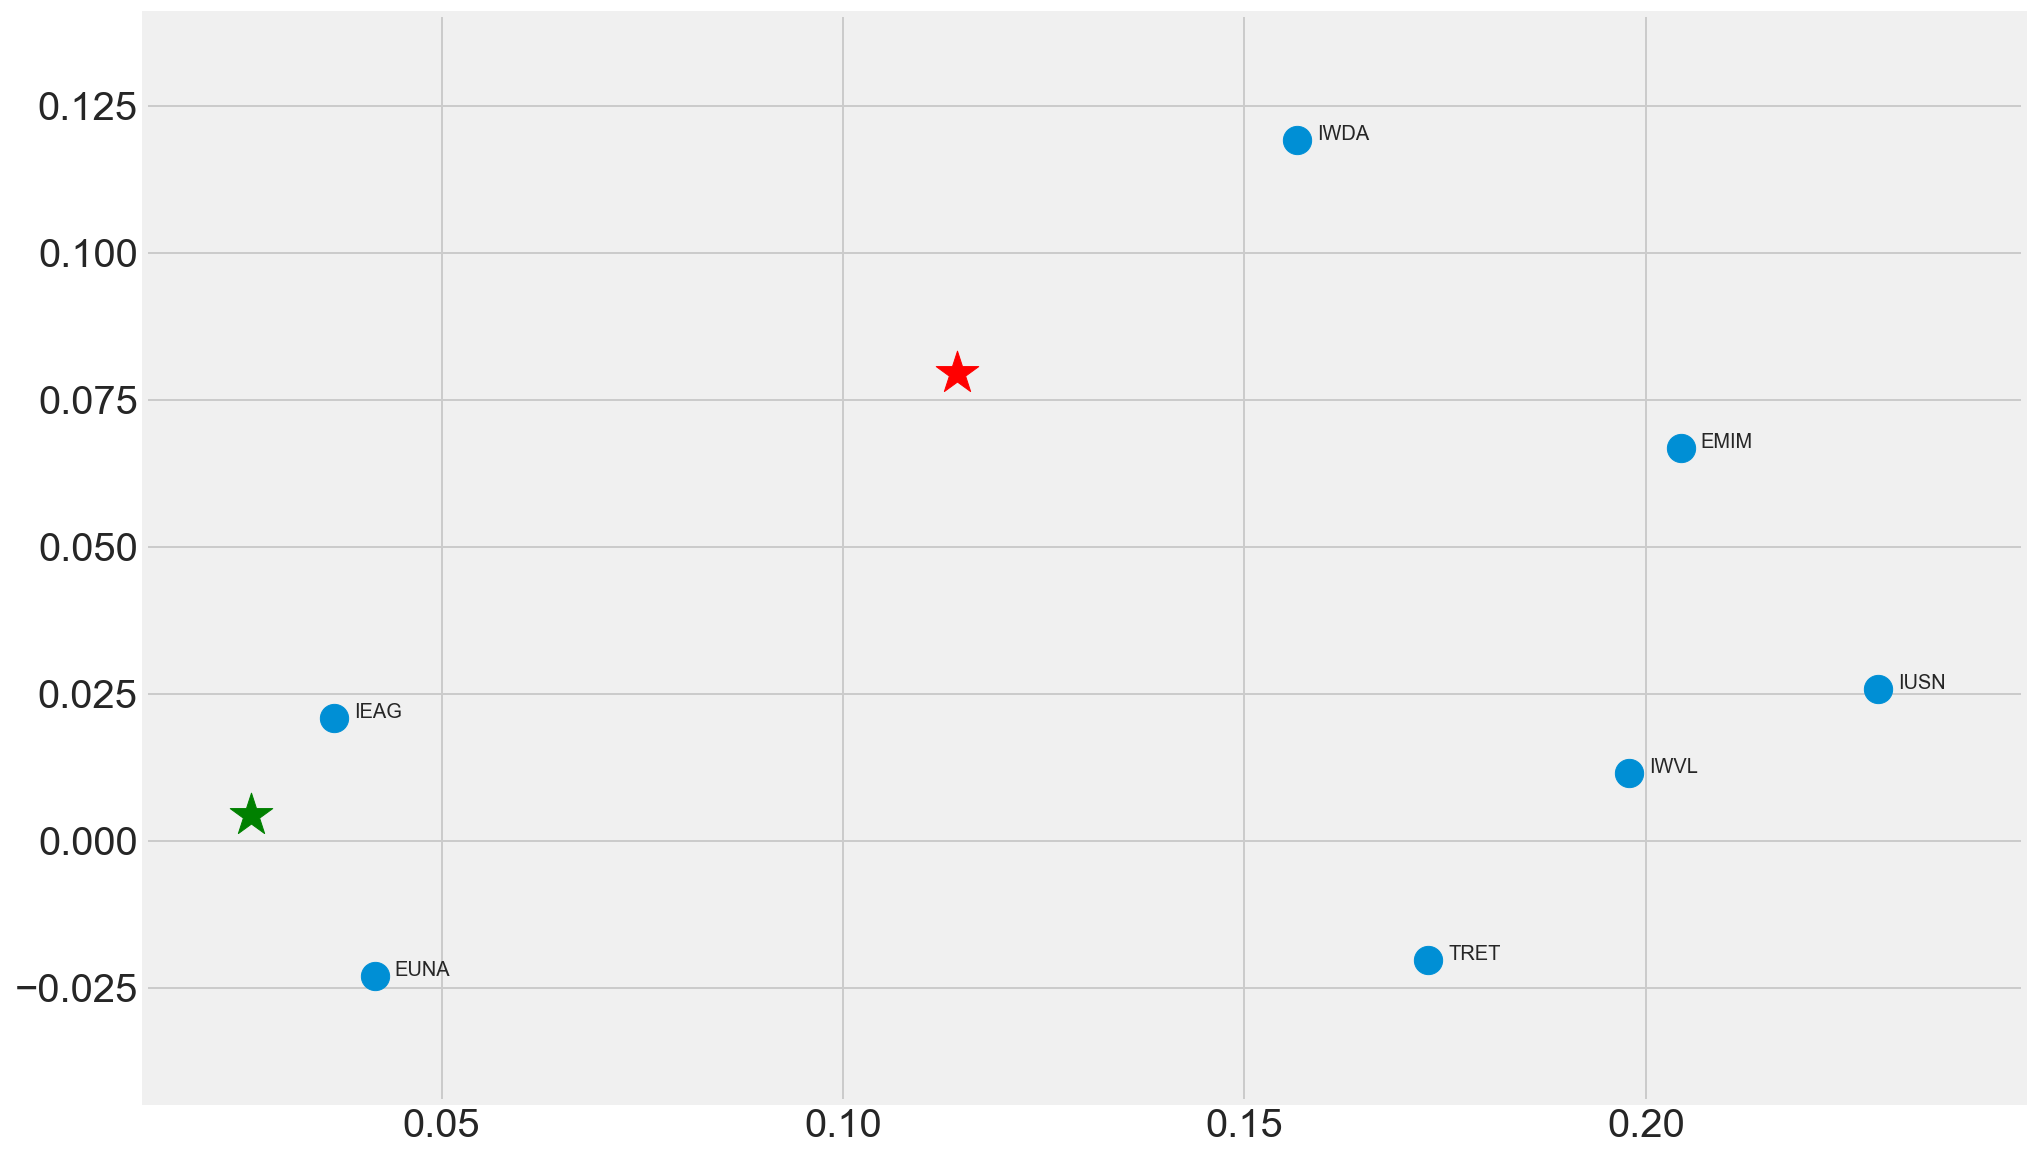

In [20]:
# Test the display of the efficient frontier

portfolio = [IWDA, EMIM, IWVL, IUSN, TRET, EUNA, IEAG]
names = ['IWDA', 'EMIM', 'IWVL', 'IUSN', 'TRET', 'EUNA', 'IEAG']
description = ['Developed Markets', 'Emerging Markets', 'World Small Cap', 'World Value', 'REIT', 'EU bond ETF', 'Global bond ETF']

portfolio = apply_perc_change(portfolio)

num_portfolios = 20
risk_free_rate = 0.17 / 100

display_ef_with_selected(portfolio, names, num_portfolios, risk_free_rate, max_return= 0.25, num_samples = 10)

## Returns since inception

In [39]:
for idx in range(len(portfolio_dict['names'])):
    print_return_since_inception(portfolio_dict['frames'][idx], portfolio_dict['names'][idx])

The returns since inception 2009-10-13 for "IWDA" is nan%
The returns since inception 2014-06-02 for "EMIM" is nan%
The returns since inception 2015-02-17 for "IWVL" is 4.18%
The returns since inception 2018-04-26 for "IUSN" is 0.0%
The returns since inception 2011-04-15 for "TRET" is 38.79%
The returns since inception 2017-12-15 for "EUNA" is 6.18%
The returns since inception 2009-05-14 for "IEAG" is 25.06%


## Daily, Monthly and Yearly returns

In [40]:
intersection_list = set(list_df[0]['Date']).intersection(set(list_df[1]['Date']))
for df in list_df[2:]:
    intersection_list.intersection(set(df['Date']))
    
common_dates = pd.Series(list(intersection_list))  

NameError: name 'list_df' is not defined

In [ ]:
EMIM['Date'] = pd.to_datetime(EMIM['Date'])
EMIM.set_index('Date', inplace = True)

daily_return = EMIM['Adj Close'].pct_change()
monthly_returns = EMIM['Adj Close'].resample('M').ffill().pct_change()


In [ ]:
fig = plt.figure()
#ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
plt.plot(daily_return)
plt.xlabel("Date")
plt.ylabel("Percent")
plt.title("EMIM daily returns data")
plt.show()

In [ ]:
fig = plt.figure()
#ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
plt.plot(monthly_returns)
plt.xlabel("Date")
plt.ylabel("Percent")
plt.title("EMIM monthly returns data")
plt.show()

In [ ]:
print(f'Mean monthly returns for "EMIM": {monthly_returns.mean()*100}%')

In [ ]:
fig = plt.figure()
#ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
daily_return.plot.hist(bins = 60)
plt.xlabel("Daily returns %")
plt.ylabel("Percent")
plt.title("EMIM daily returns data")

plt.show()

In [ ]:
#Cumulative returns

cum_returns = (daily_return + 1).cumprod()

fig = plt.figure()
cum_returns.plot()
plt.xlabel("Date")
plt.ylabel("Growth of $1 investment")
plt.title("EMIM daily cumulative returns data")
plt.show()

In [ ]:
cum_returns = (monthly_returns + 1).cumprod()

fig = plt.figure()
plt.plot(cum_returns)
plt.xlabel("Date")
plt.ylabel("Growth of $1 investment")
plt.title("EMIM Monthly cumulative returns data")
plt.show()

# Compute daily returns

In [ ]:
EMIM['Date'] = pd.to_datetime(EMIM['Date'])
EMIM.set_index('Date', inplace = True)

daily_return = EMIM['Adj Close'].pct_change()


# Things that did not work

In [ ]:
# Find the common dates.
common_dates = pd.Series(list(set(EMIM['Date']).intersection(set(IWDA['Date']))))


same_IWDA = IWDA[IWDA['Date'].isin(common_dates)]
same_EMIM = EMIM[EMIM['Date'].isin(common_dates)]


In [ ]:
# Compute covariance and correlation matrix
array_IWDA = same_IWDA['Adj Close']
array_EMIM = same_EMIM['Adj Close']
matrix = np.array([array_IWDA, array_EMIM])
covMatrix = np.cov(matrix, bias=True)
corrMatrix = np.corrcoef(matrix)


In [ ]:
print(f"The covariance matrix is: \n {covMatrix}")
print('\n')
print(f"The correlation matrix is: \n {corrMatrix}")

In [ ]:
# Compute the mean stock price

mean_IWDA = same_IWDA['Adj Close'].mean()
mean_EMIM = same_EMIM['Adj Close'].mean()

In [ ]:
#Put all of the stocks in the same matri

# Set date as index
EMIM['Date'] = pd.to_datetime(EMIM['Date'])
EMIM.set_index('Date', inplace = True)



In [ ]:
def set_date_to_index(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe.set_index('Date', inplace = True)

In [ ]:
# Set dates to index
set_date_to_index(EMIM)
set_date_to_index(IWDA)
set_date_to_index(IUSN)
set_date_to_index(IWVL)
set_date_to_index(EUNA)
set_date_to_index(IEAG)
set_date_to_index(TRET)
